### 1.准备数据

In [1]:
import torch 
from torchvision import datasets, transforms

# 定义转换器
my_trans = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize([0.5],[0.5])])
# 下载数据
trainset = datasets.FashionMNIST('MNIST_data/',
                                   download=True,
                                   train=True,
                                   transform=my_trans)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('MNIST_data/',
                                   download=True,
                                   train=False,
                                   transform=my_trans)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

### 2.构建模型

In [12]:
from torch import nn, optim
import torch.nn.functional as F

class Classify(nn.Module):
    def __init__(self):
        super().__init__()
        self.full_connect1 = nn.Linear(784, 256)
        self.full_connect2 = nn.Linear(256, 128)
        self.full_connect3 = nn.Linear(128, 64)
        self.full_connect4 = nn.Linear(64,10)
        
    def forward(self,x):
        x = x.view(x.shape[0],-1)
        x = F.relu(self.full_connect1(x))
        x = F.relu(self.full_connect2(x))
        x = F.relu(self.full_connect3(x))
        x = F.log_softmax(self.full_connect4(x), dim=1)
        
        return x

In [35]:
"""检验未训练的模型的正确率"""
classify_test1 = Classify() 
images_test1, labels_test1 = next(iter(testloader))
ps_test = torch.exp(classify_test1(images_test1))
print(f'test1的预测概率分布形状：{ps_test.shape}')

# 跨列（dim=1）选择出值最大的那  1  个值， 值赋给top_value, 所属的类号赋给top_class
top_value, top_class = ps_test.topk(1,dim=1)
print('top_value.shape:',top_value.shape,'\ntop_class.shape:',top_class.shape)

# 检验正确率(为了保证形状匹配，记得把labels.shape从1x64转变为64x1)
equals = top_class==labels_test1.view(labels_test1.shape[0],-1)
# 为了求均值，必须转化为浮点数
equals_float = equals.type(torch.FloatTensor)
accuracy_test1 = torch.mean(equals_float)
print(f'未训练模型准确率为{accuracy_test1.item()*100} %')

test1的预测概率分布形状：torch.Size([64, 10])
top_value.shape: torch.Size([64, 1]) 
top_class.shape: torch.Size([64, 1])
未训练模型准确率为1.5625 %


### 3.开始训练模型

In [42]:
# 新建模型实例
classify = Classify()
# 定义损失函数
loss_function = nn.NLLLoss()
# 定义优化函数
optimizer = optim.Adam(classify.parameters(),lr=0.001)

epochs = 10
for i in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # 优化器梯度清零
        optimizer.zero_grad()
        # 前向传播(得到log_softmax)
        output = classify(images)
        # 计算损失
        loss = loss_function(output, labels)
        # 误差反向传播
        loss.backward()
        # 优化器更新模型参数
        optimizer.step()        
        # 把本次遍历训练样本的误差累加计算
        running_loss += loss
    # 计算每次epoch的平均损失    
    print(f'训练{i}的训练误差为{running_loss/len(trainloader)}')

训练0的训练误差为0.5161175727844238
训练1的训练误差为0.3763822913169861
训练2的训练误差为0.33433690667152405
训练3的训练误差为0.3097183108329773
训练4的训练误差为0.29188773036003113
训练5的训练误差为0.27661216259002686
训练6的训练误差为0.26100483536720276
训练7的训练误差为0.25246095657348633
训练8的训练误差为0.24017423391342163
训练9的训练误差为0.22863127291202545


### 4.用测试集评价模型

In [50]:
# 指标1：计算测试集损失
with torch.no_grad():
    avg_loss=0
    for images_test, labels_test in testloader:
        output_test = classify(images_test)
        loss_test = loss_function(output_test, labels_test)
        avg_loss += loss_test
    print(f'模型平均误差：{avg_loss/len(testloader)}')


模型平均误差：0.36107581853866577


In [55]:
# 指标2： 准确率
with torch.no_grad():
    avg_acc = []
    # 每次从测试集中取出64个样本
    for images_test, labels_test in testloader:
        # 得到测试结果（一连串取了对数的概率分布）
        output_test = classify(images_test)
        # 取概率最大的一个值作为预测的类别
        top_value, top_class = output_test.topk(1,dim=1)
        # 判断预测与真实值之间的异同（1为同，0为异）
        equals = top_class==labels_test.view(labels_test.shape[0],-1)
        # 把这一连串0和1取平均值就可以知道正确率（这批次64个样本的正确率）
        accuracy = torch.mean(equals.type(torch.FloatTensor))
        # 把这批次的正确率存放到
        avg_acc.append(accuracy.item())
# print(avg_acc)
print(f'平均准确率为: {sum(avg_acc)/len(avg_acc)*100}%')

平均准确率为: 87.64928343949045%


# 动态损失可视化版
###  这次会在训练的同时计算训练的损失和测试的损失


In [66]:
model_act = Classify()
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model_act.parameters(), lr=0.001)

epochs = 30
step = 0

train_losses = []
test_losses = []
for i in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model_act(images)
        loss = loss_function(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # 每个epochs都来计算一次测试集的损失
    else:
        test_loss_batch_sum = 0
        accuracy_batch_sum = 0
        
        # Turn off grad to save memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                log_ps_test = model_act(images)
                loss = loss_function(log_ps_test, labels)
                test_loss_batch_sum += loss.item()
                
                ps_test = torch.exp(log_ps_test)
                top_value, top_class = ps_test.topk(1,dim=1)
                equals = top_class==labels.view(*top_class.shape)
                accuracy = torch.mean(equals.type(torch.FloatTensor))
                accuracy_batch_sum += accuracy
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss_batch_sum/len(testloader))
        
        print(f'epoch{i+1}of{epochs}',
             'Training_loss: {:.3f}'.format(running_loss/len(trainloader)),
             'Test_loss: {:.3f}'.format(test_loss_batch_sum/len(testloader)),
             'Accuracy: {:.3f}'.format(accuracy_batch_sum/len(testloader)))
        

epoch1of30 Training_loss: 0.522 Test_loss: 0.414 Accuracy: 0.853
epoch2of30 Training_loss: 0.377 Test_loss: 0.430 Accuracy: 0.845
epoch3of30 Training_loss: 0.339 Test_loss: 0.361 Accuracy: 0.867
epoch4of30 Training_loss: 0.317 Test_loss: 0.363 Accuracy: 0.868
epoch5of30 Training_loss: 0.296 Test_loss: 0.343 Accuracy: 0.879
epoch6of30 Training_loss: 0.275 Test_loss: 0.370 Accuracy: 0.873
epoch7of30 Training_loss: 0.265 Test_loss: 0.343 Accuracy: 0.877
epoch8of30 Training_loss: 0.249 Test_loss: 0.348 Accuracy: 0.880
epoch9of30 Training_loss: 0.238 Test_loss: 0.338 Accuracy: 0.884
epoch10of30 Training_loss: 0.232 Test_loss: 0.332 Accuracy: 0.885
epoch11of30 Training_loss: 0.218 Test_loss: 0.348 Accuracy: 0.884
epoch12of30 Training_loss: 0.211 Test_loss: 0.360 Accuracy: 0.880
epoch13of30 Training_loss: 0.200 Test_loss: 0.340 Accuracy: 0.886
epoch14of30 Training_loss: 0.193 Test_loss: 0.345 Accuracy: 0.885
epoch15of30 Training_loss: 0.184 Test_loss: 0.377 Accuracy: 0.883
epoch16of30 Trainin

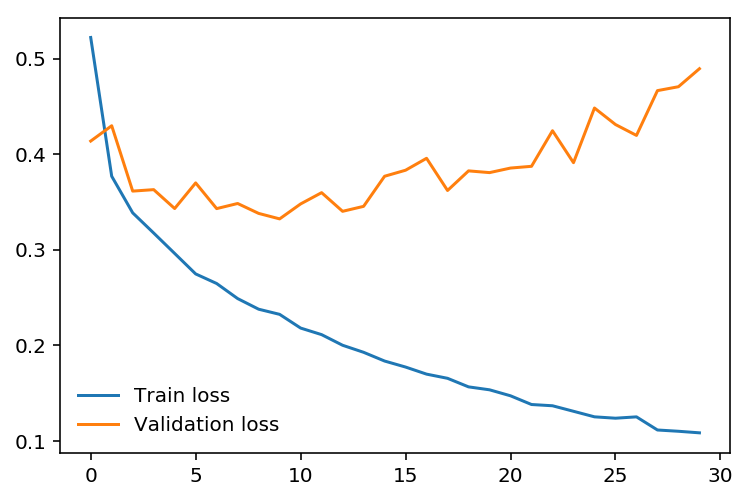

In [71]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

#### 上图出现了过拟合现象，下面添加正则化

In [72]:
from torch import nn, optim
import torch.nn.functional as F

"""使用nn.dropout可以在前向传播中随机使某个单元失效，以防止过拟合"""
class Classify_Dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.full_connect1 = nn.Linear(784, 256)
        self.full_connect2 = nn.Linear(256, 128)
        self.full_connect3 = nn.Linear(128, 64)
        self.full_connect4 = nn.Linear(64,10)
        
        # 添加dropout函数
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self,x):
        x = x.view(x.shape[0],-1)
        
        # 在每层激活函数前先使用dropout函数随机使一些单元失效
        x = self.dropout(F.relu(self.full_connect1(x)))
        x = self.dropout(F.relu(self.full_connect2(x)))
        x = self.dropout(F.relu(self.full_connect3(x)))
        
        # 最后一层softmax函数不用dropout因为我们要完整的10个单元预测
        x = F.log_softmax(self.full_connect4(x), dim=1)
        
        return x

In [74]:
model_drop = Classify_Dropout()
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model_drop.parameters(), lr=0.001)

epochs = 30
step = 0

train_losses = []
test_losses = []
for i in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model_drop(images)
        loss = loss_function(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # 每个epochs都来计算一次测试集的损失
    else:
        test_loss_batch_sum = 0
        accuracy_batch_sum = 0
        
        # Turn off grad to save memory and computations
        with torch.no_grad():
            """因为在验证模型的时候不用再dropout,
            所以我们把模型切换到评估模式evaluation mode"""
            model_drop.eval()
            
            for images, labels in testloader:
                log_ps_test = model_drop(images)
                loss = loss_function(log_ps_test, labels)
                test_loss_batch_sum += loss.item()
            
                ps_test = torch.exp(log_ps_test)
                top_value, top_class = ps_test.topk(1,dim=1)
                equals = top_class==labels.view(*top_class.shape)
                accuracy = torch.mean(equals.type(torch.FloatTensor))
                accuracy_batch_sum += accuracy
                        
        """在评价完测试集后，要切换回去训练模式，
        否则下一个epoch中，dropout会失效"""
        model_drop.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss_batch_sum/len(testloader))
        
        print(f'epoch{i+1} of {epochs}',
             ' Training_loss:{:.3f}'.format(running_loss/len(trainloader)),
             ' Test_loss:{:.3f}'.format(test_loss_batch_sum/len(testloader)),
             ' Accuracy:{:.3f}'.format(accuracy_batch_sum/len(testloader)))
        

epoch1 of 30  Training_loss:0.602  Test_loss:0.449  Accuracy:0.836
epoch2 of 30  Training_loss:0.434  Test_loss:0.433  Accuracy:0.845
epoch3 of 30  Training_loss:0.399  Test_loss:0.431  Accuracy:0.841
epoch4 of 30  Training_loss:0.373  Test_loss:0.390  Accuracy:0.861
epoch5 of 30  Training_loss:0.357  Test_loss:0.366  Accuracy:0.864
epoch6 of 30  Training_loss:0.342  Test_loss:0.369  Accuracy:0.868
epoch7 of 30  Training_loss:0.330  Test_loss:0.352  Accuracy:0.869
epoch8 of 30  Training_loss:0.319  Test_loss:0.344  Accuracy:0.878
epoch9 of 30  Training_loss:0.315  Test_loss:0.353  Accuracy:0.873
epoch10 of 30  Training_loss:0.302  Test_loss:0.352  Accuracy:0.872
epoch11 of 30  Training_loss:0.298  Test_loss:0.349  Accuracy:0.879
epoch12 of 30  Training_loss:0.291  Test_loss:0.330  Accuracy:0.881
epoch13 of 30  Training_loss:0.286  Test_loss:0.331  Accuracy:0.886
epoch14 of 30  Training_loss:0.278  Test_loss:0.329  Accuracy:0.884
epoch15 of 30  Training_loss:0.275  Test_loss:0.339  Accu

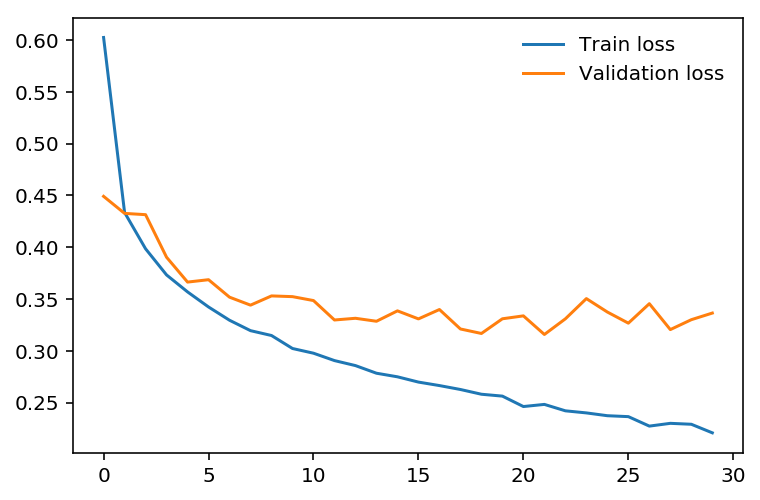

In [75]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

"""再看一下添加了正则化的训练会不会降低过拟合"""
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

### 保存模型方便下次调用

In [84]:
"""查看模型信息并保存"""

torch.save(model_drop.state_dict(),'cloth_classify.pth')
"""
再次取用需要用
info = torch.load('cloth.pth')
new_model.load_state_dict(info)
"""
print('Clothing_classify_model:\n\n',model_drop,'\n')
print('The state dict keys:\n\n',model_drop.state_dict().keys())

Clothing_classify_model:

 Classify_Dropout(
  (full_connect1): Linear(in_features=784, out_features=256, bias=True)
  (full_connect2): Linear(in_features=256, out_features=128, bias=True)
  (full_connect3): Linear(in_features=128, out_features=64, bias=True)
  (full_connect4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
) 

The state dict keys:

 odict_keys(['full_connect1.weight', 'full_connect1.bias', 'full_connect2.weight', 'full_connect2.bias', 'full_connect3.weight', 'full_connect3.bias', 'full_connect4.weight', 'full_connect4.bias'])


### 载入保存过的模型

In [101]:
"""
假设这里是另一个notebook，没有前面的cell，那么要载入以前的模型时候，
模型的创建要继承以前的类，只需要把以前定义的模型类复制过来，跑一遍，
然后就可以继承模型类来生成新的、结构与类一样的模型，这时候载入cloth_classify文件，
载入以前训练好的weights,bias，就可以得到以前训练好的模型了
"""

from torch import nn, optim
import torch.nn.functional as F
class Classify_Dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.full_connect1 = nn.Linear(784, 256)
        self.full_connect2 = nn.Linear(256, 128)
        self.full_connect3 = nn.Linear(128, 64)
        self.full_connect4 = nn.Linear(64,10)
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self,x):
        x = x.view(x.shape[0],-1)
        x = self.dropout(F.relu(self.full_connect1(x)))
        x = self.dropout(F.relu(self.full_connect2(x)))
        x = self.dropout(F.relu(self.full_connect3(x)))
        x = F.log_softmax(self.full_connect4(x), dim=1)
        return x


new_model = Classify_Dropout()
info = torch.load('cloth_classify.pth')
new_model.load_state_dict(info)

new_model

Classify_Dropout(
  (full_connect1): Linear(in_features=784, out_features=256, bias=True)
  (full_connect2): Linear(in_features=256, out_features=128, bias=True)
  (full_connect3): Linear(in_features=128, out_features=64, bias=True)
  (full_connect4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)